In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from tensorflow.keras import models,layers
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dhanimacbull","key":"6bf6e551c33ff36e076b84e067f43ec4"}'}

In [5]:
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 68 Dec 10 04:38 kaggle.json


In [6]:
!kaggle datasets download -d tolgadincer/labeled-chest-xray-images

 98% 1.15G/1.17G [00:07<00:00, 137MB/s]
100% 1.17G/1.17G [00:07<00:00, 158MB/s]


In [7]:
!rm -rf Data
# !rm -rf no
# !rm -rf yes

In [8]:
!unzip labeled-chest-xray-images

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2558319-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2559035-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2565226-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2568157-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2597757-0002.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-263932-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646645-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2646923-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2655558-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2659844-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-0001.jpeg  
  inflating: chest_xray/train/NORMAL/NORMAL-2675017-00

In [22]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.85):
      print("\Accuracy telah mencapai >92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [23]:
TRAINING_DIR = "chest_xray/train"
VALIDATION_DIR = "chest_xray/test"
 
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    fill_mode='nearest'
)
 
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))
 
validation_datagen = ImageDataGenerator(
    rescale=1.0/255
)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                        class_mode='categorical',
                                                        target_size=(150, 150))

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [26]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "chest_xray/train",
    seed=123,
    shuffle=True,
    image_size=(150,150),
    batch_size=32
)

Found 5232 files belonging to 2 classes.


In [27]:
class_names = dataset.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [28]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 150, 150, 3)
[1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1]


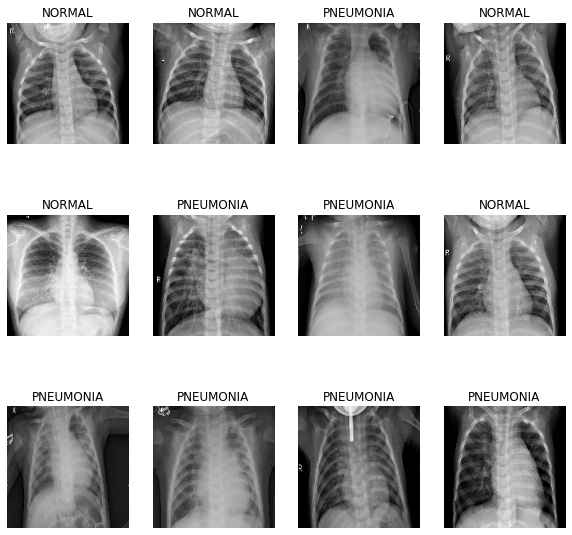

In [29]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [34]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [30]:
pre_trained_model = MobileNetV2(weights="imagenet", include_top=False,
                                input_tensor=Input(shape=(150, 150, 3)))
 
for layer in pre_trained_model.layers:
    layer.trainable = False
 
last_output = pre_trained_model.output
 
x = tf.keras.layers.Flatten(name="flatten")(last_output)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dense(2, activation='softmax')(x)
 
model = tf.keras.models.Model(pre_trained_model.input, x)
 
int_lr = 1e-4
num_epochs = 20
 
optimizer = tf.optimizers.Adam(lr=int_lr)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
 
H = model.fit(train_generator,
              epochs=num_epochs,
              validation_data=validation_generator,
              batch_size=2048,
              callbacks=[callbacks])

Epoch 1/20
164/164 [==============================] - 181s 1s/step - loss: 0.3669 - accuracy: 0.8610 - val_loss: 0.3764 - val_accuracy: 0.8285
Epoch 2/20
164/164 [==============================] - 173s 1s/step - loss: 0.2310 - accuracy: 0.9027 - val_loss: 0.2699 - val_accuracy: 0.8894


first image to predict
actual label: PNEUMONIA
1/1 [==============================] - 1s 1s/step
predicted label: PNEUMONIA


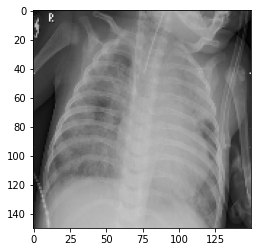

In [36]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 44ms/step


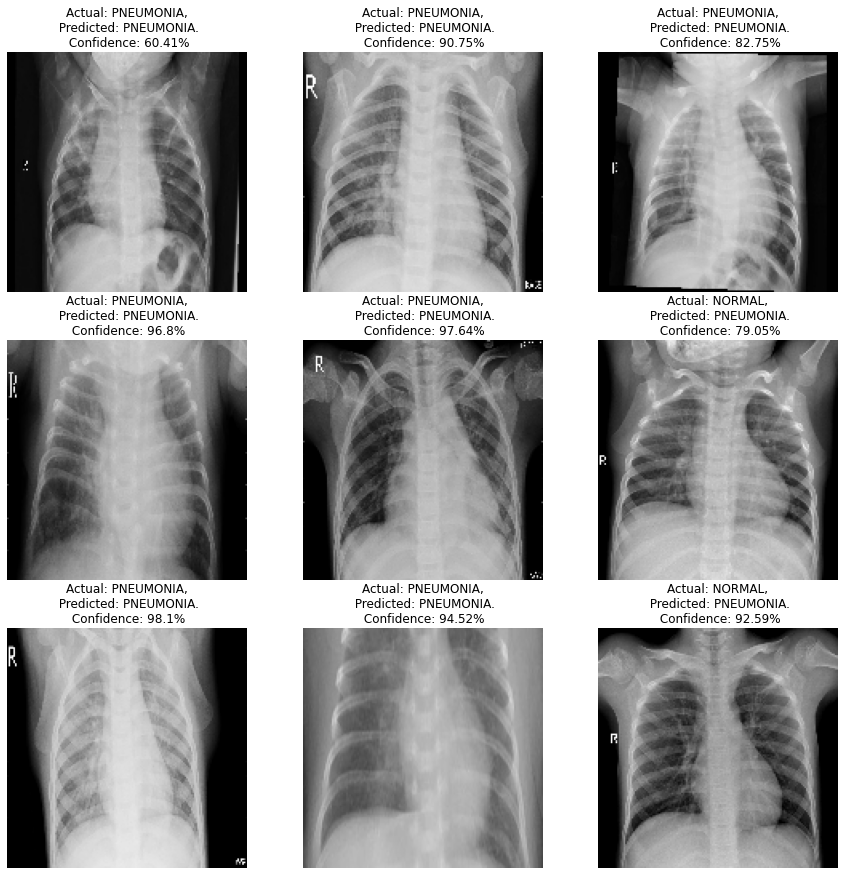

In [38]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [40]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

In [41]:
model.save("models/fruits.h5")

In [42]:
!zip -r /content/models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/1/ (stored 0%)
  adding: content/models/1/keras_metadata.pb (deflated 95%)
  adding: content/models/1/assets/ (stored 0%)
  adding: content/models/1/saved_model.pb (deflated 91%)
  adding: content/models/1/variables/ (stored 0%)
  adding: content/models/1/variables/variables.index (deflated 77%)
  adding: content/models/1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/models/fruits.h5 (deflated 8%)
